In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
os.environ["TAVILY_API_KEY"]

'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'

In [2]:
import os 
from langchain.chat_models import init_chat_model

llm =  init_chat_model("google_genai:gemini-2.5-flash")

/home/badri/miniconda3/envs/hitomi/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1758898373.531901   29239 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [1]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="smollm2",
    temperatur=0,
)

/home/badri/miniconda3/envs/hitomi/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [4]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs:dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]

        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],

                )
            )
            return {"messages": outputs}
        
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


In [5]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()


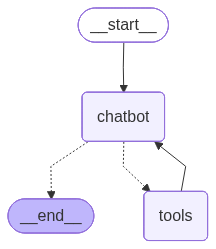

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass 

In [ ]:
def stream_graph_updates(user_input:str):
    for event in graph.stream({'messages': [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant: ", value["messages"][-1].content)

while True:
    try:
        user_input = input("user: ")
        if user_input.lower() in ["quite", "exit", "q"]:
            print("bye")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "what do you know about gary marcus?"
        print("User: "+ user_input)
        stream_graph_updates(user_input)
        break



Assistant:  The query cannot be answered with the provided tools.
Assistant:  
Assistant:  {"query": "whether in india", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.selectiveasia.com/india-holidays/weather", "title": "Best time to visit India | weather by month - climate - Selective Asia", "content": "# When is the best time to visit India? Generally, the best time to visit India is December through to March during the cool, dry season but always keep in mind that India is a large country with a diverse climate and varied weather conditions. The monsoon drops rain on large parts of the country from mid-June to early September making central and north east India in particular very hard going, with flooding a real risk. You're far better off visiting other parts of India at this time of year that don't get so drenched - such as Rajasthan or Tamil Nadu. Whilst the monsoon from mid-June to early September tips large amounts of rain on central

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = l
lm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [12]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [16]:
config = {"configurable": {"thread_id": "1"}}



In [17]:
user_input ="my name is badri."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
    )
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

my name is badri.
================================== Ai Message ==================================

Hello Badri. How can I help you today?


In [20]:
user_input = "I got a ias application form where it needs some deatilas of me to fill in. Now I stop at the blank name. tell me what to fill there" 


# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I got a ias application form where it needs some deatilas of me to fill in. Now I stop at the blank name. tell me what to fill there
================================== Ai Message ==================================

You should fill in "Badri" in the name blank.


In [23]:
snapshot = graph.get_state(config)
snapshot.pretty_print()

AttributeError: 'StateSnapshot' object has no attribute 'pretty_print'

In [1]:
from typing import Annotated,TypedDict

from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt



/home/badri/miniconda3/envs/hitomi/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)



In [3]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="smollm2",
    temperatur=0,
)

In [4]:
@tool
def human_assistance(query:str) -> str:
    """Request assistance from a human"""
    human_response = interrupt({"query": query})
    return human_response["data"]


search_tool = TavilySearch(max_results=2)
tools = [search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls)<=1
    return {"messages": [message]}

graph_builder.add_node("chatbot",chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [5]:
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [7]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (18f1cc47-ce00-4417-96c3-bbb3846fb9eb)
 Call ID: 18f1cc47-ce00-4417-96c3-bbb3846fb9eb
  Args:
    query: Expert guidance for building an AI agent.


In [9]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (18f1cc47-ce00-4417-96c3-bbb3846fb9eb)
 Call ID: 18f1cc47-ce00-4417-96c3-bbb3846fb9eb
  Args:
    query: Expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I've requested assistance for you! The experts recommend checking out LangGraph for building your AI agent, as they find it more reliable and extensible than simpler autonomous agents.


In [10]:
snapshot = graph.get_state(config)
snapshot.next

()

In [16]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

# --- State definition ---
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# --- Human assistance tool ---
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    result = interrupt({"query": query})
    return str(result["data"])  # ensure a string is returned

# --- Tavily search tool ---
tavily_tool = TavilySearch(max_results=2)

# --- Register tools ---
tools = [tavily_tool, human_assistance]

# --- Bind LLM with tools ---
llm_with_tools = llm.bind_tools(tools)

# --- Chatbot function ---
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Ensure only one tool call per message
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}  # return the actual message object

# --- Add nodes to graph ---
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# --- Add edges and conditions ---
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
